# Подготовка данных и создание сети


In [1]:
%tensorflow_version 1.x

! pip install git+https://github.com/rcmalli/keras-vggface.git

TensorFlow 1.x selected.
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-q1279gpr
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-q1279gpr
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=52ca68437e9b09f2dd8f2db0b541fc034691bffa267e43a85361a8dbb6f85a6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tamrdi4r/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') # or VGGFace() as default

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.




165445632/165439116 [==============================] - 2s 0us/step


In [4]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:01, 106MB/s] 


'resnet50face.h5'

In [5]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

In [6]:
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [7]:
from pathlib import Path
from collections import Counter

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:02, 48.3MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 33.0MB/s]


'train_val_split_utk.csv'

In [8]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

23708
['21_0_2_20170116165220655.jpg.chip.jpg', '43_0_4_20170104205649403.jpg.chip.jpg', '35_1_1_20170117010340078.jpg.chip.jpg']


In [9]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg


,img_name,age,race,gender
0,23_1_2_20170116164541818.jpg.chip.jpg,0.198276,2,1
1,1_0_2_20161219200203132.jpg.chip.jpg,0.008621,2,0
2,70_0_0_20170120140346584.jpg.chip.jpg,0.603448,0,0
3,40_1_0_20170117092248467.jpg.chip.jpg,0.344828,0,1
4,19_1_3_20170104223253815.jpg.chip.jpg,0.163793,3,1


In [10]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [11]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

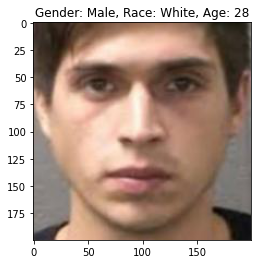

In [12]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


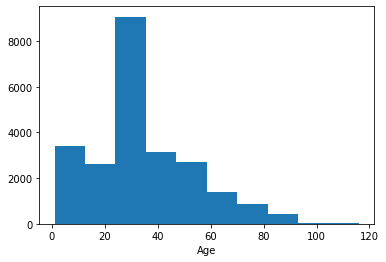

In [13]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from tensorflow.keras.preprocessing import image
def preprocess_input_facenet(image):
    """
    image -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    
    preprocessed = utils.preprocess_input(image, version=2)
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

In [15]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    img = np.copy(vggface_image)
    img[..., 0] -= 91.4953
    img[..., 1] -= 103.8827
    img[..., 2] -= 131.0912
    img = img[..., ::-1].astype(np.uint8)
    

    # < YOUR CODE ENDS HERE >
    return img


In [16]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [17]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

# Распознование расы


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model.trainable = False
BATCH_SIZE = 64
IMAGE_SIZE = 224
race_model = tf.keras.Sequential()
race_model.add(base_model)
race_model.add(tf.keras.layers.Dense(128, activation='relu'))
race_model.add(tf.keras.layers.Dense(64, activation='relu'))
race_model.add(tf.keras.layers.Dense(5, activation='softmax'))
race_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

train_race_gen = image_gen.flow_from_dataframe(dataframe=df_train, 
                                               directory=str(data_folder),
                                               x_col='img_name',
                                               y_col='race',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='sparse',
                                               batch_size=BATCH_SIZE)

val_race_gen = image_gen.flow_from_dataframe(dataframe=df_val,
                                             directory=str(data_folder),
                                             x_col='img_name',
                                             y_col='race',
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=BATCH_SIZE,
                                             class_mode='sparse',
                                             shuffle=False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [20]:
path = Path("model_race")
path.mkdir(exist_ok=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "best_checkpoint_race.hdf5"  
cpt_path =str(path) + '\\' + str(cpt_filename)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

In [ ]:
race_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 23,832,005
Trainable params: 23,778,885
Non-trainable params: 53,120
_________________________________________________________________


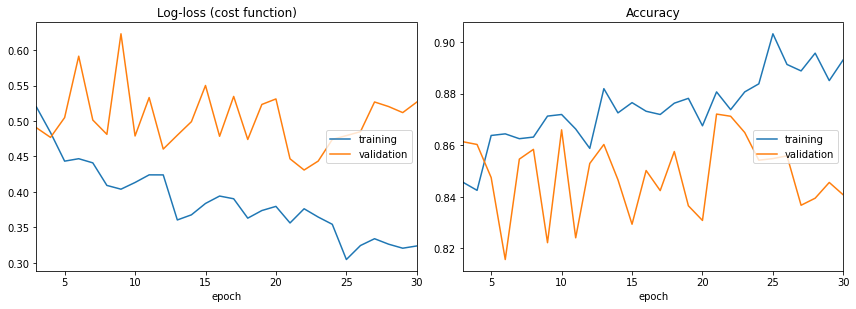

Log-loss (cost function):
training   (min:    0.305, max:    1.205, cur:    0.324)
validation (min:    0.431, max:    0.623, cur:    0.527)

Accuracy:
training   (min:    0.623, max:    0.903, cur:    0.893)
validation (min:    0.816, max:    0.872, cur:    0.841)

Epoch 00030: val_loss did not improve from 0.43089
25/25 [==============================] - 39s 2s/step - loss: 0.3238 - acc: 0.8931 - val_loss: 0.5267 - val_acc: 0.8407


In [21]:
#Прогонка по всей сети без заморозки
race_model.fit_generator(train_race_gen, steps_per_epoch=25, epochs=30, verbose=1, callbacks=[PlotLossesCallback(), checkpoint], validation_data=val_race_gen)

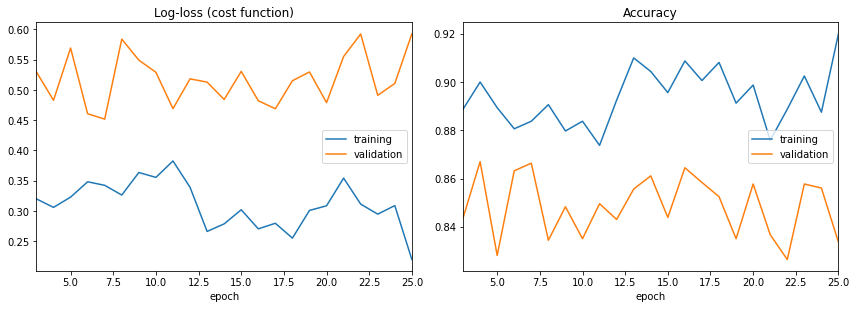

Log-loss (cost function):
training   (min:    0.220, max:    0.383, cur:    0.220)
validation (min:    0.452, max:    0.593, cur:    0.593)

Accuracy:
training   (min:    0.874, max:    0.920, cur:    0.920)
validation (min:    0.826, max:    0.867, cur:    0.834)

Epoch 00025: val_loss did not improve from 0.43089
25/25 [==============================] - 39s 2s/step - loss: 0.2197 - acc: 0.9200 - val_loss: 0.5929 - val_acc: 0.8336


In [23]:
num_layer = 163
for layer in base_model.layers[:num_layer]:
  layer.trainable = False
race_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
race_model.fit_generator(train_race_gen, steps_per_epoch=25, epochs=25, verbose=1, callbacks=[PlotLossesCallback(), checkpoint],
                         validation_data=val_race_gen)

In [22]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

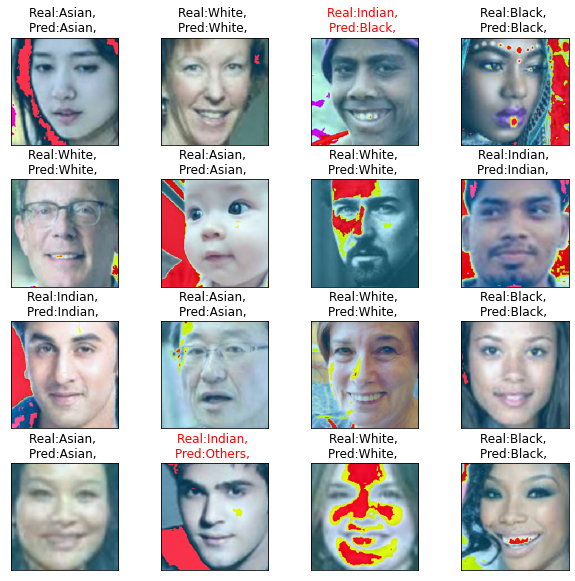

In [24]:
sample_validation_images, sample_validation_labels = next(val_race_gen)
predicted = race_model.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

# Распознование пола


In [25]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

gender_model = tf.keras.Sequential()
gender_model.add(base_model)
gender_model.add(tf.keras.layers.Dense(256, activation='relu'))
gender_model.add(tf.keras.layers.Dense(128, activation='relu'))
gender_model.add(tf.keras.layers.Dense(64, activation='relu'))
gender_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
gender_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

train_gender_gen = image_gen.flow_from_dataframe(dataframe=df_train, 
                                               directory=str(data_folder),
                                               x_col='img_name',
                                               y_col='gender',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE)

val_gender_gen = image_gen.flow_from_dataframe(dataframe=df_val,
                                             directory=str(data_folder),
                                             x_col='img_name',
                                             y_col='gender',
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary',
                                             shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

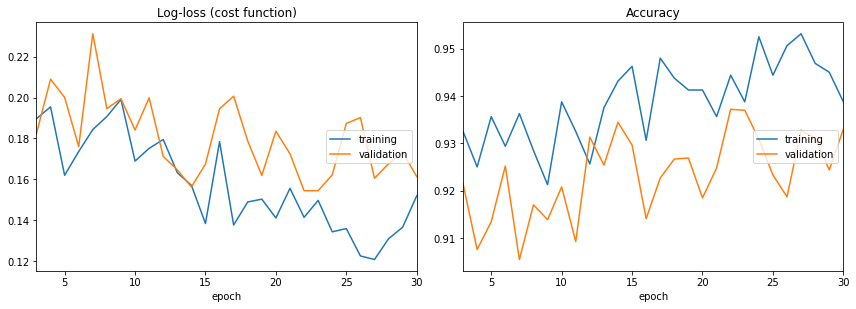

Log-loss (cost function):
training   (min:    0.121, max:    0.493, cur:    0.152)
validation (min:    0.154, max:    0.304, cur:    0.161)

Accuracy:
training   (min:    0.773, max:    0.953, cur:    0.939)
validation (min:    0.878, max:    0.937, cur:    0.933)

Epoch 00030: val_loss did not improve from 0.15447
25/25 [==============================] - 39s 2s/step - loss: 0.1520 - acc: 0.9388 - val_loss: 0.1614 - val_acc: 0.9330


In [27]:
gender_model.fit_generator(train_gender_gen, steps_per_epoch=25, epochs=30, verbose=1, callbacks=[PlotLossesCallback(), checkpoint],
                         validation_data=val_gender_gen)

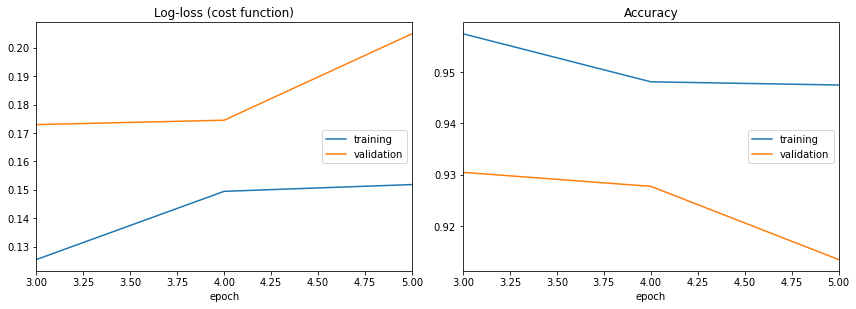

Log-loss (cost function):
training   (min:    0.121, max:    0.152, cur:    0.152)
validation (min:    0.173, max:    0.217, cur:    0.205)

Accuracy:
training   (min:    0.947, max:    0.957, cur:    0.947)
validation (min:    0.913, max:    0.930, cur:    0.913)

Epoch 00005: val_loss did not improve from 0.15447
25/25 [==============================] - 39s 2s/step - loss: 0.1518 - acc: 0.9475 - val_loss: 0.2049 - val_acc: 0.9134


In [29]:
num_layer = 155
for layer in base_model.layers[:num_layer]:
  layer.trainable = False
gender_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
gender_model.fit_generator(train_gender_gen, steps_per_epoch=25, epochs=5, verbose=1, callbacks=[PlotLossesCallback(), checkpoint],
                         validation_data=val_gender_gen)

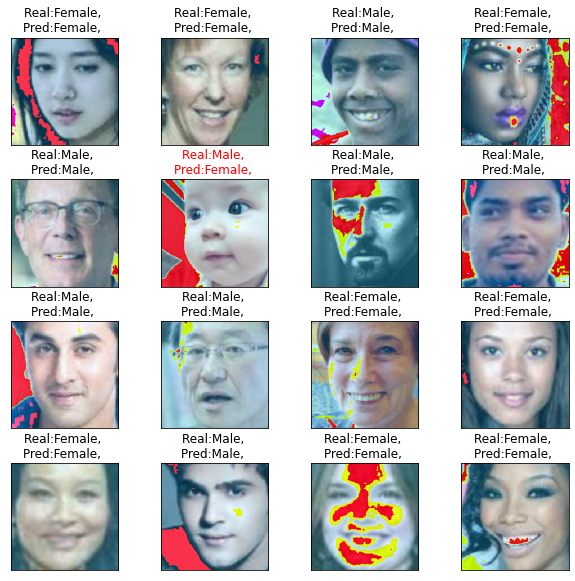

In [30]:
sample_validation_images, sample_validation_labels = next(val_gender_gen)
predicted = gender_model.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

# Multitask learning

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2048)         23561152    input_6[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 256)          524544      model_1[5][0]                    
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 128)          32896       dense_28[0][0]                   
____________________________________________________________________________________________

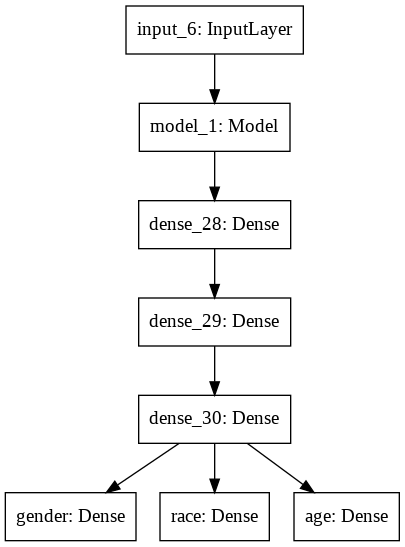

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# < YOUR CODE STARTS HERE >
base_model_output = base_model(input_layer)
dense_output_1 = tf.keras.layers.Dense(256, activation='relu')(base_model_output)
dense_output_2 = tf.keras.layers.Dense(128, activation='relu')(dense_output_1)
dense_output_3 = tf.keras.layers.Dense(64, activation='relu')(dense_output_2)
first_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_output_3)
second_output = tf.keras.layers.Dense(5, activation='sigmoid', name='race')(dense_output_3)
third_output = tf.keras.layers.Dense(1, activation='softmax', name='age')(dense_output_3)
model = tf.keras.Model(inputs=input_layer, outputs=[first_output, second_output, third_output])
# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[1].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[2].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


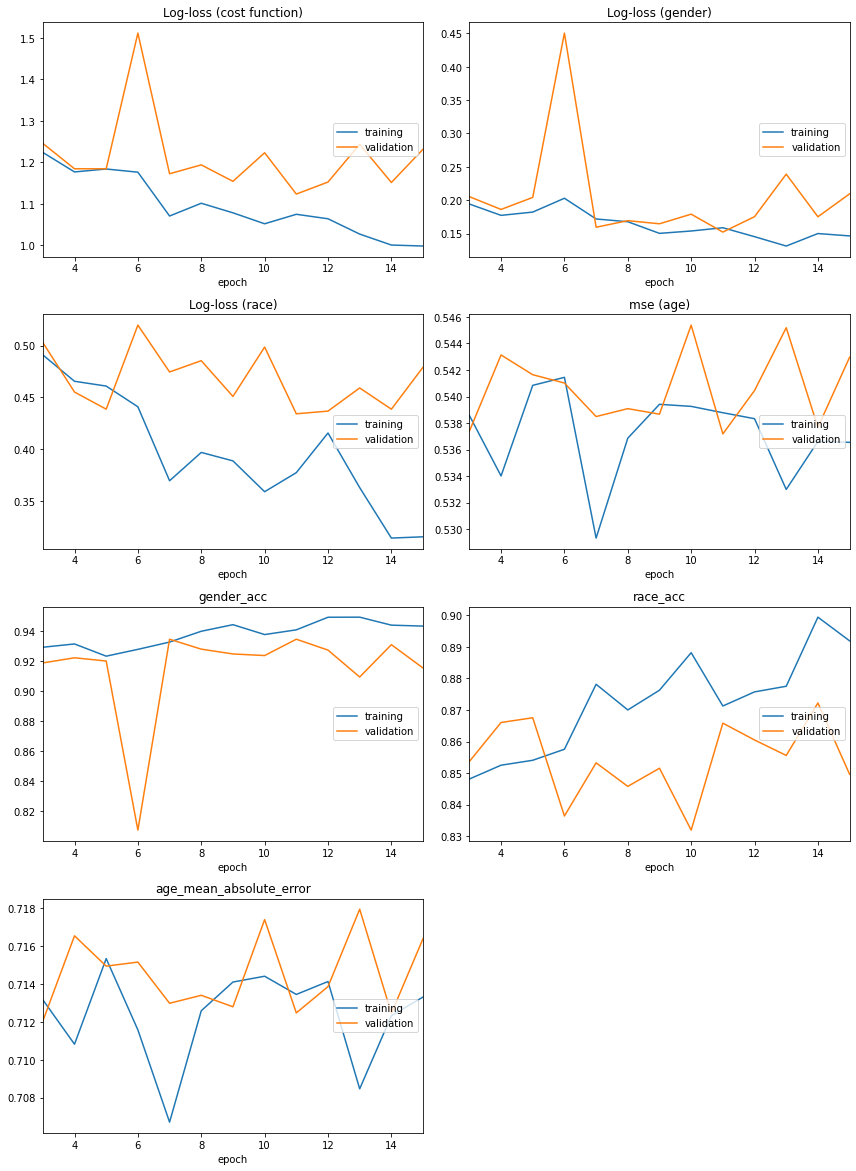

Log-loss (cost function):
training   (min:    0.998, max:    2.090, cur:    0.998)
validation (min:    1.124, max:    1.887, cur:    1.232)

Log-loss (gender):
training   (min:    0.131, max:    0.352, cur:    0.146)
validation (min:    0.152, max:    0.451, cur:    0.210)

Log-loss (race):
training   (min:    0.314, max:    1.199, cur:    0.315)
validation (min:    0.434, max:    1.042, cur:    0.479)

mse (age):
training   (min:    0.529, max:    0.541, cur:    0.537)
validation (min:    0.537, max:    0.545, cur:    0.543)

gender_acc:
training   (min:    0.851, max:    0.949, cur:    0.943)
validation (min:    0.807, max:    0.934, cur:    0.915)

race_acc:
training   (min:    0.240, max:    0.899, cur:    0.892)
validation (min:    0.512, max:    0.872, cur:    0.850)

age_mean_absolute_error:
training   (min:    0.707, max:    0.715, cur:    0.713)
validation (min:    0.712, max:    0.718, cur:    0.716)

Epoch 00015: val_age_mean_absolute_error did not improve from 0.71205
50/50

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)